# NOTES:
This is still identical to the mouse dataset as I have still not found out how to find autism genes for flies, is there any such thing as autism in flies? need to look into what the equivalent targets in flies 

It appears that apris has some good data for the fly primary isoform, oh, it actually has something good for mouse as well. I can start implementing this soon.  

## Step 1:
Let the program know where to find your tools file.

In [1]:
import sys, os
sys.path.append(os.path.join(os.path.realpath(".."), "Tools"))

## Step 2:
Load up all of the necessary packages

In [2]:
from plastid import BAMGenomeArray,GTF2_TranscriptAssembler,Transcript
import numpy as np
import pandas as pd
from plastid.plotting.plots import *
import utilities as utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
from Bio import SeqIO
from Bio.Alphabet import generic_dna
from Bio.Seq import Seq

%matplotlib inline

## Step 3:
define the paths to our reference genome and annotation files as well as the path to our list of autism spectrum disorder (ASD) genes

In [3]:
reference_path = "/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/genome/dmel/"
asd_genes_path = "/home/keeganfl/Desktop/measuring_binding_domains/data/"

## Step 4: 
load the transcript and genome files so that we can find the sequence of each gene

In [4]:
# Loading up the transcrip[t information.
transcripts = list(GTF2_TranscriptAssembler(open(reference_path + "Drosophila_melanogaster.BDGP6.32.103.gtf"),return_type=Transcript))

# Loading up the genome information. 
genome = SeqIO.to_dict(SeqIO.parse(open(reference_path + "Drosophila_melanogaster.BDGP6.32.dna.toplevel.fa"),"fasta"))

## Step 5:
Create a dataframe that contains the gene name, gene length, and the counts for the FMRP target mRNA sequences

In [5]:
# Create a dataframe with all of the count data I want. 
temp_counts = utils.ACUK_WGGA_counter(transcripts, genome)

---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/measuring_binding_domains/Tools/utilities.py, line 150:

148     # get the count density for each region.
149     density_cds = np.array(total_cds)/np.array(lengths_cds)
150     density_utr5 = np.array(total_utr5)/np.array(lengths_utr5)
151     density_utr3 = np.array(total_utr3)/np.array(lengths_utr3)
152     density_all = np.array(total_all)/np.array(lengths_all)

---------------------------------------------------------------------------
---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/measuring_binding_domains/Tools/utilities.py, line 151:

149     density_cds = np.array(total_cds)/np.array(lengths_cds)
150     density_utr5 = np.array(total_utr5)/np.array(lengths_utr5)
151     density_utr3 = np.array(total_utr3)/np.arra

## Step 6:
Load up the list of APRIS genes. This list will include the transcript IDs of all of the primary isoforms, and will be used to select a single transcript for all genes.

In [6]:
# Load up the Apris genes. 
prin_trans = pd.read_csv(asd_genes_path + "apris_fly_data.txt", names = ["gene_name", "???", "gene_id", "rank"])

In [7]:
# Merge the count table with the table of ASD gene names and include an indicator column.
fly_counts = pd.merge(temp_counts, prin_trans, how="left", on="gene_id", indicator = True)

# Only keep counts with a transcript ID that matched one of the APRIS primary IDs.
fly_counts = fly_counts.loc[fly_counts._merge == "both"].copy()

# Drop any duplicate genes (duplicates may remain if multiple transcripts have identical cds regions).
fly_counts.drop_duplicates(subset ="gene_name_x",keep = "first", inplace = True) 

# Remove unnecesary columns. 
fly_counts.drop(columns = ["gene_name_y", "???", "rank", "_merge"], inplace = True)

## Step 7:
Load up a list containing all of the autism spectrum genes

In [8]:
asd_gene_names = pd.read_csv(asd_genes_path + "asd_genes_fly.csv", names = ["gene_name"])

## Step 8:
merge the asd_gene_names and the mouse counts together based on the shared gene names

In [9]:
temp_df = pd.merge(fly_counts, asd_gene_names, how="left", left_on = "gene_name_x", right_on = "gene_name", indicator = True)

temp_df = temp_df.reset_index(drop=True)

# remove extremely long genes as they effect the analysis
temp_df = temp_df.drop(temp_df[temp_df.lengths_all > 35000].index)

## Step 9:
split the merged table into asd_genes and non_asd_genes tables

In [10]:
# split it into asd_genes and non_asd_genes tables
asd_genes = temp_df.loc[temp_df._merge == "both"].copy()

non_asd_genes = temp_df.loc[temp_df._merge == "left_only"].copy()

# drop the unecessary columns
non_asd_genes.drop(columns = ["_merge"], inplace = True)

# Reset the indices
asd_genes = asd_genes.reset_index(drop=True)
non_asd_genes = non_asd_genes.reset_index(drop=True)

## Step 10
Create a set of violin plots that show the distribution of FMRP binding site density in autism genes and non-autism genes. 

In [11]:
short_asd = asd_genes.query("lengths_cds < 1500")
short_other = non_asd_genes.query("lengths_cds < 1500")

long_asd = asd_genes.query("lengths_cds > 4000")
long_other = non_asd_genes.query("lengths_cds > 4000 & lengths_all < 60000")

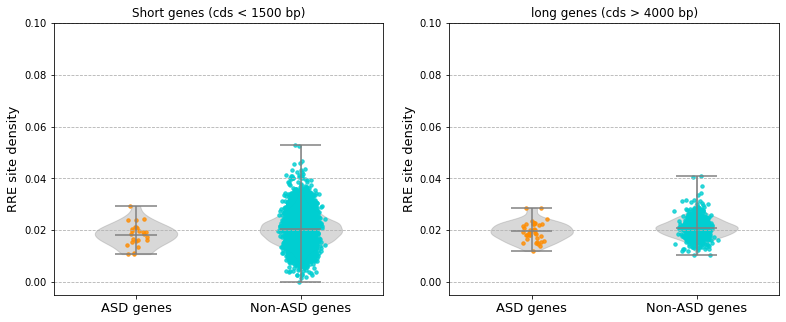

In [12]:
# Creating axes objects
fig, ax = plt.subplots(1,2, figsize = (13,5))

# Adding violin plots
violin_parts = ax[0].violinplot([short_asd.density_all, short_other.density_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
violin_parts = ax[1].violinplot([long_asd.density_all, long_other.density_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
# Adding dotplots
x = np.random.normal(1, 0.04, size=len(short_asd.density_all))
ax[0].scatter(x, short_asd.density_all, s = 12, color = "darkorange", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(short_other.density_all))
ax[0].scatter(x, short_other.density_all, s = 12,  color = "darkturquoise", alpha=0.8)

x = np.random.normal(1, 0.04, size=len(long_asd.density_all))
ax[1].scatter(x, long_asd.density_all, s = 12, color = "darkorange", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(long_other.density_all))
ax[1].scatter(x, long_other.density_all, s = 12,  color = "darkturquoise", alpha=0.8)

# Determining x and y axis limits
ax[0].set_xlim(0.5,2.5)
ax[0].set_ylim(-0.005,0.1)
ax[1].set_xlim(0.5,2.5)
ax[1].set_ylim(-0.005,0.1)

# Labelling the axes.
positions = (1,2)
labels = ("ASD genes", "Non-ASD genes")
ax[0].set_xticks(positions, labels, fontsize = 13)
ax[1].set_xticks(positions, labels, fontsize = 13)
ax[0].set_ylabel("RRE site density", fontsize = 13)
ax[1].set_ylabel("RRE site density", fontsize = 13)

# Giving plot titles.
ax[0].set_title("Short genes (cds < 1500 bp)")
ax[1].set_title("long genes (cds > 4000 bp)")

# Creating grid lines
ax[0].yaxis.grid(linestyle = "--")
ax[1].yaxis.grid(linestyle = "--")

In [13]:
# Use the permutation test to determine if the FMRP binding site density is significantly
# different for ASD genes.
short_test = stats.ttest_ind(short_asd.density_all, short_other.density_all, equal_var = True,
                nan_policy = "omit", alternative = "greater")

long_test = stats.ttest_ind(long_asd.density_all, long_other.density_all, equal_var = True,
                nan_policy = "omit", alternative = "greater")
print(short_test)
print(long_test)

Ttest_indResult(statistic=-1.8247111599249508, pvalue=0.9659606842998333)
Ttest_indResult(statistic=-2.375582623981506, pvalue=0.9911260036460087)


## Step 11
Create a set of violin plots that show the distribution of total FMRP binding sites and CDS length for autism and non-autism genes

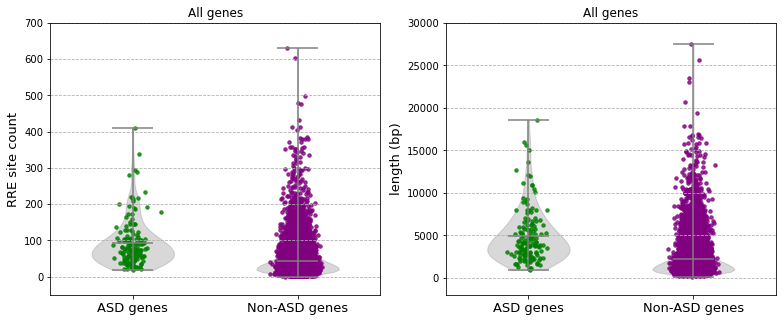

In [14]:
# Creating axes objects
fig, ax = plt.subplots(1,2, figsize = (13,5))

# Adding violin plots
violin_parts = ax[0].violinplot([asd_genes.total_all, non_asd_genes.total_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
violin_parts = ax[1].violinplot([asd_genes.lengths_all, non_asd_genes.lengths_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
# Adding dotplots
x = np.random.normal(1, 0.04, size=len(asd_genes.total_all))
ax[0].scatter(x, asd_genes.total_all, s = 12, color = "green", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(non_asd_genes.total_all))
ax[0].scatter(x, non_asd_genes.total_all, s = 12,  color = "purple", alpha=0.8)

x = np.random.normal(1, 0.04, size=len(asd_genes.lengths_all))
ax[1].scatter(x, asd_genes.lengths_all, s = 12, color = "green", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(non_asd_genes.lengths_all))
ax[1].scatter(x, non_asd_genes.lengths_all, s = 12,  color = "purple", alpha=0.8)

# Determining x and y axis limits
ax[0].set_xlim(0.5,2.5)
ax[0].set_ylim(-50,700)
ax[1].set_xlim(0.5,2.5)
ax[1].set_ylim(-2000,30000)

# Labelling the axes.
positions = (1,2)
labels = ("ASD genes", "Non-ASD genes")
ax[0].set_xticks(positions, labels, fontsize = 13)
ax[1].set_xticks(positions, labels, fontsize = 13)
ax[0].set_ylabel("RRE site count", fontsize = 13)
ax[1].set_ylabel("length (bp)", fontsize = 13)

# Giving plot titles.
ax[0].set_title("All genes")
ax[1].set_title("All genes")

# Creating grid lines
ax[0].yaxis.grid(linestyle = "--")
ax[1].yaxis.grid(linestyle = "--")

In [15]:
# Use the permutation test to determine if the total FMRP binding sites and length
# Are significantly different between all other genes. 
short_test = stats.ttest_ind(short_asd.total_all, short_other.total_all, equal_var = True,
                nan_policy = "omit", permutations = 3000)

long_test = stats.ttest_ind(long_asd.lengths_all, long_other.lengths_all, equal_var = True,
                nan_policy = "omit", permutations = 3000)
print(short_test)
print(long_test)

Ttest_indResult(statistic=2.809298004624047, pvalue=0.008)
Ttest_indResult(statistic=3.8979450737116133, pvalue=0.0)


# Conclusions:
from the data I am currently able to observe, I can conclude that although the total number of binding sites is higher in ASD gene populations, this is basically entirely dependent on the fact that the ASD genes are generally longer. When looking at binding site frequency/density, there is no biologically significant change even if there is a slight statistical significance.  